In [21]:
import os
import librosa
import numpy as np
import IPython.display as ipd
import matplotlib.pyplot as plt

from scipy.io import wavfile
from sklearn.cluster import KMeans
from python_speech_features import mfcc
from python_speech_features import delta
from sklearn.metrics import accuracy_score


In [2]:
datalabel = ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']
train_audio_path = r"D:\Project\data\train\audio" #with noise

all_wave = []
all_label = []
mfcccc = []
mfcclist = []


for label in datalabel:
    waves = [f for f in os.listdir(train_audio_path + '/' + label) if f.endswith('.wav')]
    print("Now is", label)
    for wav in waves:
        (rate, sig) = wavfile.read(train_audio_path + '/' + label + '/' + wav)
        if (len(sig) == 16000) :
            all_wave.append(sig)
            all_label.append(label)

            mfcccc = mfcc(sig, 16000, appendEnergy = True, winstep = 0.01, nfft = 1024)
            # delta
            d_mfcc_feat = delta(mfcccc, 2)
            # delta-delta
            dd_mfcc_feat = delta(d_mfcc_feat,2)
    
            mtotal = np.array(mfcccc.T.tolist() + d_mfcc_feat.T.tolist() + dd_mfcc_feat.T.tolist())
            mfcclist.append(mtotal.T.tolist())
            

print()
print("MISSION COMPLETE!!!")

Now is zero
Now is one
Now is two
Now is three
Now is four
Now is five
Now is six
Now is seven
Now is eight
Now is nine

MISSION COMPLETE!!!


In [3]:
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, Dropout, Flatten, BatchNormalization, LSTM, TimeDistributed, Bidirectional
from keras.layers import Activation, Bidirectional, ConvLSTM2D
#import tensorflow as tf

Using TensorFlow backend.


In [4]:
model = Sequential()
# 1st Conv1D layer
model.add(Conv1D(64, 8, padding='valid', activation='relu', strides=1, input_shape=(99, 39)))
model.add(MaxPooling1D(3))
model.add(Dropout(0.3))

# 2nd Conv1D layer
model.add(Conv1D(32, 6, padding='valid', activation='relu', strides=1))
model.add(MaxPooling1D(3))
model.add(Dropout(0.3))

# Flatten layer
model.add(Flatten())

# 1st Dense Layer
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))

# output layer
model.add(Dense(len(datalabel), activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 92, 64)            20032     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 30, 64)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 64)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 25, 32)            12320     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 8, 32)             0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 8, 32)             0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 256)              

In [6]:
# Convert the output labels to integer encoded
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(all_label)
classes = list(le.classes_)


# convert the integer encoded labels to a one-hot vector since it is a multi-classification problem
import tensorflow as tf
print("Tensorflow Version: {}".format(tf.__version__))

y = tf.keras.utils.to_categorical(y, num_classes=len(datalabel))


# the input array of conv1d must be a 3D array so make it into a 3D array
all_wave = np.array(mfcclist).reshape(-1, 99, 39)


## Split
from sklearn.model_selection import train_test_split
x_tr, x_val, y_tr, y_val = train_test_split(
    np.array(mfcclist), np.array(y), stratify=y, test_size = 0.2, random_state=777, shuffle=True)

Tensorflow Version: 2.1.0


In [7]:
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, min_delta=0.0001)
Learning_Rate_Function = ReduceLROnPlateau(monitor = 'val_acc',
                                          patience = 3,
                                          verbose = 1,
                                          factor = 0.5,
                                          min_lr = 0.00001)



history = model.fit(x_tr, y_tr,
                    epochs=500, 
                    callbacks=[es, Learning_Rate_Function],
                    batch_size=256, 
                    validation_data=(x_val, y_val))

Train on 17249 samples, validate on 4313 samples
Epoch 1/500
17249/17249 [==============================] - 5s 277us/step - loss: 3.5124 - accuracy: 0.1210 - val_loss: 2.2765 - val_accuracy: 0.1289
Epoch 2/500
  768/17249 [>.............................] - ETA: 3s - loss: 2.2686 - accuracy: 0.1302

C:\Users\USER\Anaconda3\envs\py36\lib\site-packages\keras\callbacks\callbacks.py:1042: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


17249/17249 [==============================] - 4s 230us/step - loss: 2.2009 - accuracy: 0.1742 - val_loss: 2.0636 - val_accuracy: 0.3042
Epoch 3/500
17249/17249 [==============================] - 4s 229us/step - loss: 1.9300 - accuracy: 0.2920 - val_loss: 1.6428 - val_accuracy: 0.4491
Epoch 4/500
17249/17249 [==============================] - 4s 244us/step - loss: 1.6536 - accuracy: 0.4039 - val_loss: 1.3060 - val_accuracy: 0.6186
Epoch 5/500
17249/17249 [==============================] - 4s 245us/step - loss: 1.3461 - accuracy: 0.5289 - val_loss: 0.9236 - val_accuracy: 0.7438
Epoch 6/500
17249/17249 [==============================] - 4s 243us/step - loss: 1.1061 - accuracy: 0.6127 - val_loss: 0.6963 - val_accuracy: 0.7946
Epoch 7/500
17249/17249 [==============================] - 4s 241us/step - loss: 0.9371 - accuracy: 0.6822 - val_loss: 0.5809 - val_accuracy: 0.8294
Epoch 8/500
17249/17249 [==============================] - 4s 240us/step - loss: 0.7931 - accuracy: 0.7332 - val_loss:

17249/17249 [==============================] - 4s 249us/step - loss: 0.1855 - accuracy: 0.9402 - val_loss: 0.1378 - val_accuracy: 0.9583
Epoch 57/500
17249/17249 [==============================] - 4s 251us/step - loss: 0.1761 - accuracy: 0.9458 - val_loss: 0.1422 - val_accuracy: 0.9573
Epoch 58/500
17249/17249 [==============================] - 4s 245us/step - loss: 0.1710 - accuracy: 0.9464 - val_loss: 0.1358 - val_accuracy: 0.9597
Epoch 59/500
17249/17249 [==============================] - 4s 247us/step - loss: 0.1719 - accuracy: 0.9446 - val_loss: 0.1380 - val_accuracy: 0.9585
Epoch 60/500
17249/17249 [==============================] - 4s 253us/step - loss: 0.1646 - accuracy: 0.9464 - val_loss: 0.1408 - val_accuracy: 0.9559
Epoch 61/500
17249/17249 [==============================] - 4s 241us/step - loss: 0.1632 - accuracy: 0.9476 - val_loss: 0.1371 - val_accuracy: 0.9573
Epoch 62/500
17249/17249 [==============================] - 4s 248us/step - loss: 0.1705 - accuracy: 0.9449 - val

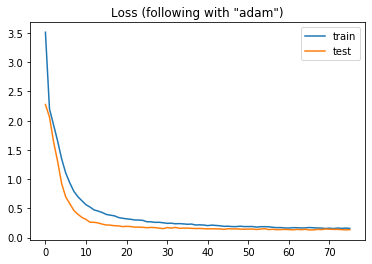

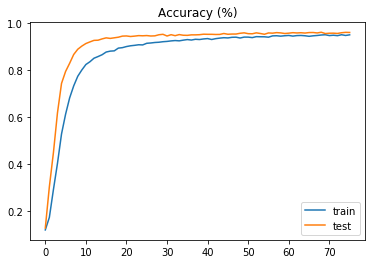

In [8]:
# visualization
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='train') 
plt.plot(history.history['val_loss'], label='test') 
plt.title('Loss (following with "adam")')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='train') 
plt.plot(history.history['val_accuracy'], label='test') 
plt.title('Accuracy (%)')
plt.legend()
plt.show()

# Test

In [10]:
datalabel = ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']
train_audio_path = r"D:\Project\student"

st_wave = []
st_label = []
st_mfcccc = []
st_mfcclist = []


for label in datalabel:
    waves = [f for f in os.listdir(train_audio_path + '/' + label) if f.endswith('.wav')]
    print("Now is", label)
    for wav in waves:
        (rate, sig) = wavfile.read(train_audio_path + '/' + label + '/' + wav)
        if (len(sig) == 16000) :
            st_wave.append(sig)
            st_label.append(label)

            mfcccc = mfcc(sig, 16000, appendEnergy = True, winstep = 0.01, nfft = 1024)
            # delta
            d_mfcc_feat = delta(mfcccc, 2)
            # delta-delta
            dd_mfcc_feat = delta(d_mfcc_feat,2)
    
            mtotal = np.array(mfcccc.T.tolist() + d_mfcc_feat.T.tolist() + dd_mfcc_feat.T.tolist())
            st_mfcclist.append(mtotal.T.tolist())

print(np.shape(st_mfcclist))
print("Test COMPLETE!")

Now is zero
Now is one
Now is two
Now is three
Now is four
Now is five
Now is six
Now is seven
Now is eight
Now is nine
(150, 99, 39)
Test COMPLETE!


In [11]:
# build a predict function
def predict(audio):
    prob = model.predict(audio.reshape(-1, 99, 39))
    index = np.argmax(prob[0])
    return classes[index]

In [23]:
pred = []
for i in range(0, len(st_wave)):
    pred.append(predict(np.array(st_mfcclist[i])))

accuracy = accuracy_score(st_label, pred)
print(accuracy)

0.9066666666666666


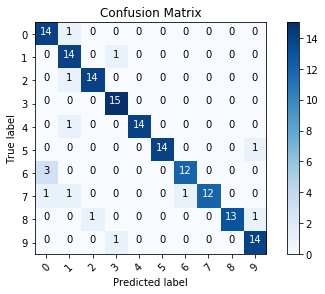

In [14]:
import itertools
def plot_confusion_matrix(cm, classes, normalize=False, title="Confusion Matrix", cmap=plt.cm.Blues):
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

from sklearn.metrics import confusion_matrix

y_pred = model.predict(np.array(st_mfcclist))
cm = confusion_matrix(np.array(st_label), pred)
plot_confusion_matrix(cm, range(0, len(datalabel)))

[ 8  8  5  8  4  5  8  8  8  6  8 11  7  7]


Text(0.5, 0, 'Predicted label')

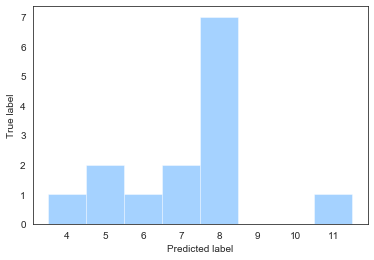

In [16]:
pos = np.array(np.where(np.array(st_label).T != np.array(pred).T))[0]
data = pos % 15
print(data)
import seaborn as sns
sns.set_style("white")

sns.distplot(data, color="dodgerblue", label="Compact",kde=False, bins=np.arange(data.min()-0.5, data.max()+1,1))
plt.ylabel('True label')
plt.xlabel('Predicted label')

# Separation

16000
1045 1045


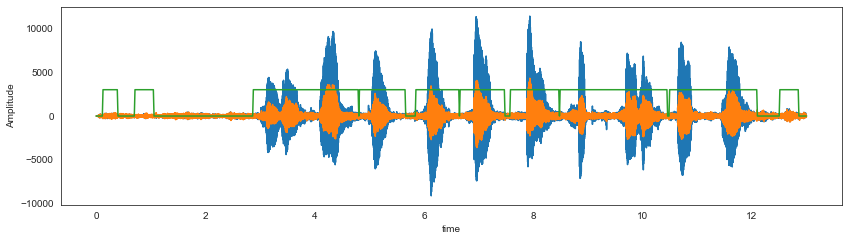

In [59]:
(rate, myauto) = wavfile.read("student9.wav")
print(rate)
sample1 = myauto.T.tolist()[0]
sample2 = myauto.T.tolist()[1]

mfcc_myauto = mfcc(np.array(sample2), rate, nfft = 1024)
    # delta
d_mfcc_feat = delta(mfcc_myauto, 2)
    # delta-delta
dd_mfcc_feat = delta(d_mfcc_feat,2)
mfcclist_myauto = np.array(mfcc_myauto.T.tolist() + d_mfcc_feat.T.tolist() + dd_mfcc_feat.T.tolist()).T


#######################################
kmeans = KMeans(n_clusters = 2)
kmeans.fit(mfcclist_myauto)
labels_myauto = kmeans.labels_
#######################################
from hmmlearn import hmm
gm = hmm.GaussianHMM(n_components=2)
gm.fit(mfcclist_myauto)
labels_myauto = gm.predict(mfcclist_myauto)
#######################################

new_labels_myauto = np.zeros(len(labels_myauto))
n = 10
for l in range(n, len(labels_myauto)-n):
    if(sum(labels_myauto[l-n:l+n] != 0)):
        new_labels_myauto[l] = 1
    
#    if (labels_myauto[l-1] == 1):
#        new_labels_myauto[l] += 1     
        
#    if (labels_myauto[l+1] == 1):
#        new_labels_myauto[l] += 1


print(len(labels_myauto), len(new_labels_myauto))



sample_rate = rate
fig = plt.figure(figsize=(14, 8)) # create a figure object
ax1 = fig.add_subplot(211) # create an axes object in the figure
ax1.set_xlabel('time')
ax1.set_ylabel('Amplitude')
ax1.plot(np.linspace(0, 13, len(myauto)), sample2)
ax1.plot(np.linspace(0, 13, len(myauto)), sample1)
ax1.plot(np.linspace(0, 13, len(labels_myauto)), new_labels_myauto*3000)


ipd.Audio(sample1, rate = rate)

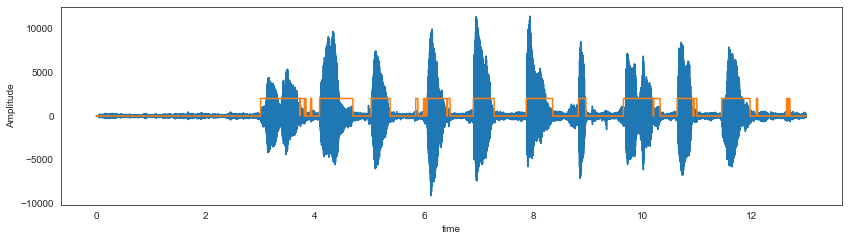

In [60]:
hahaha = np.array(sample2)
ab = abs(hahaha)

mean = 7
m_time = []
for i in range(0, len(hahaha)):
    if (mean*i+mean > len(hahaha)):
        break
    else:
        m_time.append(np.mean(hahaha[mean*i:mean*i+mean]))


##(450 is great)    
time = np.zeros(len(m_time))
for i in range(0, len(m_time)):
    if (m_time[i] < 550):# & (m_time[i] > -450)
        time[i] = 0
    else:
        time[i] = 1    

    
    
new_time = np.zeros(len(time))
for l in range(20, len(new_time)-20):
    if (sum(time[l-20:l+20]) != 0):
        new_time[l] = 1


sample_rate = len(hahaha)
fig = plt.figure(figsize=(14, 8)) # create a figure object
ax1 = fig.add_subplot(211) # create an axes object in the figure
ax1.set_xlabel('time')
ax1.set_ylabel('Amplitude')
ax1.plot(np.linspace(0, 13, len(myauto)), hahaha)
ax1.plot(np.linspace(0, 13, len(new_time)), new_time*2000)

ipd.Audio(hahaha, rate = rate)

In [61]:
if (len(new_labels_myauto) >= len(new_time)):
    u = new_labels_myauto
    v = new_time
elif  (len(new_time) > len(new_labels_myauto)):  
    u = new_time
    v = new_labels_myauto
    
long_not_zero = np.where(u != 0)
short_not_zero = np.where(v != 0)
same_unit = np.round(np.array(long_not_zero)*len(v)/len(u)) #
same_unit = same_unit.reshape(-1)
short_not_zero = np.array(short_not_zero).reshape(-1)


a = same_unit.tolist()
b = short_not_zero.tolist()
c = []

for i in range(0,1000000):
    if(a[0] == b[0]):
        c.append(a[0])
        a.pop(0)
        b.pop(0)
    elif (a[0] < b[0]):
        a.pop(0)        
    else:
        b.pop(0)
    if ((len(a) ==0) | (len(b) == 0)):
        break

        
after_compare_to_both = np.zeros(len(v))

for i in range(0, len(c)):
    after_compare_to_both[int(c[i])] = 1
new_actb = np.zeros(len(after_compare_to_both))
n = 3
for l in range(n+1, len(u)-n+1):
    if (sum(after_compare_to_both[l-n-1:l+n-1]) != 0):
        new_actb[l] = 1

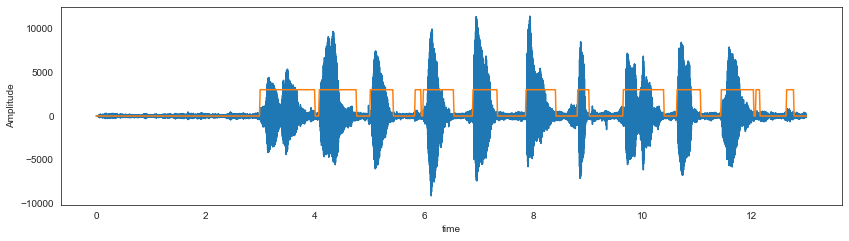

In [62]:
samples = myauto
sample_rate = rate
fig = plt.figure(figsize=(14, 8)) 
ax1 = fig.add_subplot(211) 
ax1.set_xlabel('time')
ax1.set_ylabel('Amplitude')
ax1.plot(np.linspace(0, 13, len(myauto)), hahaha)
ax1.plot(np.linspace(0, 13, len(new_actb)), new_actb*3000)

ipd.Audio(sample1, rate = rate)

In [63]:
len_new_actb = len(new_actb)

temp = 0
left = []
right = []
for i in range(0, len_new_actb):
    if (temp == 0) & (new_actb[i] != temp):
        temp = new_actb[i]
        left.append(i)
    if (temp == 1) & (new_actb[i] != temp):
        temp = new_actb[i]
        right.append(i)


length = np.array(right) - np.array(left)
new_left = []
new_right = []
count = 0
for i in range(0, len(length)):

    if length[i] > 8:
        new_right.append(right[i])
        new_left.append(left[i])
        count += 1


In [64]:
medium = (np.array(new_right) + np.array(new_left))/2
length = np.array(new_right)- np.array(new_left)
med = int(len(sample1)*medium[0]/len_new_actb)

cut_in_second = []
for i in range(0, len(new_right)):
    cutl, cutr = int(len(hahaha)*new_left[i]/len_new_actb) , int(len(hahaha)*new_right[i]/len_new_actb)
    med = int(len(hahaha)*medium[i]/len_new_actb)

    ## adapt the voice to one second
    if ((cutr - cutl) >= rate):
        print(cutl, cutr, cutr-cutl)
        minus = (cutr - cutl) - rate
        f_minus = int(minus/2)
        b_minus = minus - f_minus
        cut_in_second.append(hahaha[cutl + f_minus : cutr - b_minus])

    elif ((cutr - cutl) < rate):
        add = rate - (cutr - cutl)
        f_add = int(add/2)
        b_add = add - f_add
        if(f_add > left[i]):
            cut_in_second.append(hahaha.tolist()[0:2000] + hahaha.tolist()[(med-6000):(med+6000)] + hahaha.tolist()[0:2000])
            print(i, end = " ")
        else:
            cut_in_second.append(hahaha[int(len(hahaha)*left[i]/len_new_actb - f_add) : int(len(hahaha)*right[i]/len_new_actb) + b_add])



0 1 2 3 4 5 6 7 8 9 10 11 

In [65]:
ipd.Audio(cut_in_second[1], rate = rate)

In [85]:
pred = []
for i in range(0, len(cut_in_second)):
    samples = np.array(cut_in_second[i])

    mfcc_myauto = mfcc(samples, 16000)
    # delta
    d_mfcc_feat = delta(mfcc_myauto, 2)
    # delta-delta
    dd_mfcc_feat = delta(d_mfcc_feat,2)
    mfcclist_myauto = np.array(mfcc_myauto.T.tolist() + d_mfcc_feat.T.tolist() + dd_mfcc_feat.T.tolist()).T
    
    if (np.size(mfcclist_myauto) != 99*39):
        break
    
    rs = np.array(mfcclist_myauto).reshape(-1, 99, 39)
    pred.append(predict(rs))

    
print("predict:", pred)
ipd.Audio(sample1, rate=16000)

predict: ['nine', 'five', 'zero', 'eight', 'eight', 'five', 'five', 'eight', 'seven', 'eight', 'nine']
